In [4]:
pip install -r requirements.txt --quiet

Note: you may need to restart the kernel to use updated packages.


In [2]:
# Data Handling
import pandas as pd
import numpy as np

# Text Preprocessing
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

# Feature Engineering
from sklearn.feature_extraction.text import TfidfVectorizer

# Model Training
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import accuracy_score, classification_report

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

# Download NLTK resources
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\praka\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\praka\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\praka\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [3]:
# Load the datasets
train_data = pd.read_csv('train/train.csv',encoding='utf-8')
test_data = pd.read_csv('test/test.csv',encoding='utf-8')

# Display first 5 rows
print("Training Data:")
display(train_data.head())

print("Test Data:")
display(test_data.head())

Training Data:


,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


Test Data:


,id,comment_text
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap..."
3,00017563c3f7919a,":If you have a look back at the source, the in..."
4,00017695ad8997eb,I don't anonymously edit articles at all.


In [4]:
# Check for missing values
print("Missing Values in Train Data:\n", train_data.isnull().sum())

# Check for duplicate values
print("Duplicate Rows in Train Data:", train_data.duplicated().sum())

# Fill missing values (if any)
train_data.fillna("", inplace=True)
test_data.fillna("", inplace=True)


Missing Values in Train Data:
 id               0
comment_text     0
toxic            0
severe_toxic     0
obscene          0
threat           0
insult           0
identity_hate    0
dtype: int64
Duplicate Rows in Train Data: 0


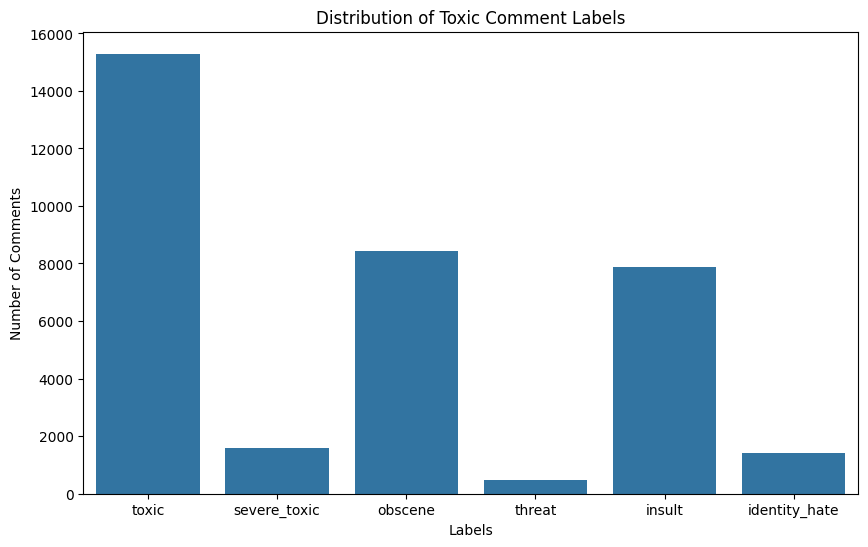

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt

# List of target columns
label_columns = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]

# Count the number of comments for each label
label_counts = train_data[label_columns].sum()

# Plot the distribution
plt.figure(figsize=(10,6))
sns.barplot(x=label_counts.index, y=label_counts.values)
plt.title("Distribution of Toxic Comment Labels")
plt.xlabel("Labels")
plt.ylabel("Number of Comments")
plt.show()

In [6]:
# Define a function for text cleaning
def clean_text(text):
    text = text.lower()  # Convert to lowercase
    text = re.sub(r'\W', ' ', text)  # Remove special characters
    text = re.sub(r'\s+', ' ', text)  # Remove extra spaces
    text = re.sub(r'\d+', '', text)  # Remove numbers
    return text

# Apply the function to comment_text
train_data["clean_text"] = train_data["comment_text"].apply(clean_text)
test_data["clean_text"] = test_data["comment_text"].apply(clean_text)

# Display cleaned text
train_data[["comment_text", "clean_text"]].head()

,comment_text,clean_text
0,Explanation\nWhy the edits made under my usern...,explanation why the edits made under my userna...
1,D'aww! He matches this background colour I'm s...,d aww he matches this background colour i m se...
2,"Hey man, I'm really not trying to edit war. It...",hey man i m really not trying to edit war it s...
3,"""\nMore\nI can't make any real suggestions on ...",more i can t make any real suggestions on imp...
4,"You, sir, are my hero. Any chance you remember...",you sir are my hero any chance you remember wh...


In [7]:
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words("english"))

# Function to process text further
def process_text(text):
    words = word_tokenize(text)  # Tokenization
    words = [word for word in words if word not in stop_words]  # Remove stopwords
    words = [lemmatizer.lemmatize(word) for word in words]  # Lemmatization
    return " ".join(words)

# Apply to dataset
train_data["processed_text"] = train_data["clean_text"].apply(process_text)
test_data["processed_text"] = test_data["clean_text"].apply(process_text)

# Display processed text
train_data[["clean_text", "processed_text"]].head()


,clean_text,processed_text
0,explanation why the edits made under my userna...,explanation edits made username hardcore metal...
1,d aww he matches this background colour i m se...,aww match background colour seemingly stuck th...
2,hey man i m really not trying to edit war it s...,hey man really trying edit war guy constantly ...
3,more i can t make any real suggestions on imp...,make real suggestion improvement wondered sect...
4,you sir are my hero any chance you remember wh...,sir hero chance remember page


In [8]:
# Convert text into numerical vectors using TF-IDF
vectorizer = TfidfVectorizer(max_features=5000, stop_words="english", ngram_range=(1,2))

# Fit on training data and transform
X_train = vectorizer.fit_transform(train_data["processed_text"])
X_test = vectorizer.transform(test_data["processed_text"])

# Define target labels
y_train = train_data[label_columns]

print("TF-IDF Vectorization Complete!")
print("Shape of X_train:", X_train.shape)
print("Shape of X_test:", X_test.shape)


TF-IDF Vectorization Complete!
Shape of X_train: (159571, 5000)
Shape of X_test: (153164, 5000)


In [9]:
# Train a Logistic Regression Model
model = OneVsRestClassifier(LogisticRegression(max_iter=200))
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred_train = model.predict(X_train)

# Evaluate model performance
print("Model Performance on Training Data:")
print(classification_report(y_train, y_pred_train))


Model Performance on Training Data:
              precision    recall  f1-score   support

           0       0.91      0.64      0.75     15294
           1       0.61      0.25      0.35      1595
           2       0.91      0.67      0.77      8449
           3       0.60      0.12      0.20       478
           4       0.82      0.56      0.67      7877
           5       0.73      0.26      0.38      1405

   micro avg       0.88      0.59      0.71     35098
   macro avg       0.76      0.42      0.52     35098
weighted avg       0.86      0.59      0.70     35098
 samples avg       0.06      0.05      0.05     35098



In [10]:
# Make predictions on the test dataset
y_pred_test = model.predict(X_test)

# Convert predictions into DataFrame
submission_df = pd.DataFrame(y_pred_test, columns=label_columns)
submission_df.insert(0, "id", test_data["id"])  # Add ID column

# Save submission file
submission_df.to_csv("submission.csv", index=False)

print("Submission file saved successfully!")


Submission file saved successfully!


In [11]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, SpatialDropout1D

In [12]:
# Set parameters for tokenization
MAX_NUM_WORDS = 5000  # Vocabulary size
MAX_SEQUENCE_LENGTH = 200  # Max words per comment
EMBEDDING_DIM = 100  # Word vector size

# Tokenize the text
tokenizer = Tokenizer(num_words=MAX_NUM_WORDS, oov_token="<OOV>")
tokenizer.fit_on_texts(train_data["processed_text"])

# Convert text into sequences
X_train_seq = tokenizer.texts_to_sequences(train_data["processed_text"])
X_test_seq = tokenizer.texts_to_sequences(test_data["processed_text"])

# Pad sequences to make them of equal length
X_train_padded = pad_sequences(X_train_seq, maxlen=MAX_SEQUENCE_LENGTH, padding="post", truncating="post")
X_test_padded = pad_sequences(X_test_seq, maxlen=MAX_SEQUENCE_LENGTH, padding="post", truncating="post")

print("Text converted to sequences and padded successfully!")
print("Shape of X_train:", X_train_padded.shape)
print("Shape of X_test:", X_test_padded.shape)


Text converted to sequences and padded successfully!
Shape of X_train: (159571, 200)
Shape of X_test: (153164, 200)


In [13]:
# Build the LSTM model
model_lstm = Sequential([
    Embedding(input_dim=MAX_NUM_WORDS, output_dim=EMBEDDING_DIM, input_length=MAX_SEQUENCE_LENGTH),
    SpatialDropout1D(0.2),
    LSTM(100, dropout=0.2, recurrent_dropout=0.2, return_sequences=True),
    LSTM(50, dropout=0.2, recurrent_dropout=0.2),
    Dense(50, activation="relu"),
    Dropout(0.2),
    Dense(6, activation="sigmoid")  # 6 output labels (multi-label classification)
])

# Compile the model
model_lstm.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

# Train the model
history = model_lstm.fit(X_train_padded, y_train, epochs=3, batch_size=64, validation_split=0.1, verbose=1)

print("LSTM Model Training Complete!")

Epoch 1/3
2244/2244 ━━━━━━━━━━━━━━━━━━━━ 1598s 709ms/step - accuracy: 0.8123 - loss: 0.1632 - val_accuracy: 0.9940 - val_loss: 0.1421
Epoch 2/3
2244/2244 ━━━━━━━━━━━━━━━━━━━━ 1747s 779ms/step - accuracy: 0.9931 - loss: 0.1419 - val_accuracy: 0.9940 - val_loss: 0.1431
Epoch 3/3
2244/2244 ━━━━━━━━━━━━━━━━━━━━ 1615s 720ms/step - accuracy: 0.9940 - loss: 0.1449 - val_accuracy: 0.9940 - val_loss: 0.1430
LSTM Model Training Complete!


In [14]:
# Make predictions using the trained LSTM model
y_pred_lstm = model_lstm.predict(X_test_padded)

# Convert probabilities to binary predictions (0 or 1)
y_pred_lstm_binary = (y_pred_lstm > 0.5).astype(int)

# Save the LSTM predictions in submission.csv 
submission_lstm = pd.DataFrame(y_pred_lstm_binary, columns=label_columns)
submission_lstm.insert(0, "id", test_data["id"])
submission_lstm.to_csv("submission_lstm.csv", index=False)

print("LSTM Submission file saved successfully!")


4787/4787 ━━━━━━━━━━━━━━━━━━━━ 353s 74ms/step
LSTM Submission file saved successfully!


In [22]:
import transformers
import tensorflow_hub as hub
from transformers import BertTokenizer, TFBertModel
from transformers import TFBertForSequenceClassification

In [23]:
# Load BERT tokenizer
tokenizer_bert = BertTokenizer.from_pretrained("bert-base-uncased")

# Tokenize text and convert into BERT input format
def encode_texts(texts, max_length=200):
    return tokenizer_bert.batch_encode_plus(
        texts.tolist(),
        max_length=max_length,
        padding="max_length",
        truncation=True,
        return_tensors="tf"
    )

# Encode training and test datasets
X_train_bert = encode_texts(train_data["processed_text"])
X_test_bert = encode_texts(test_data["processed_text"])

print("BERT Tokenization Complete!")

BERT Tokenization Complete!


In [30]:
from transformers import TFBertModel, BertTokenizer
import tensorflow as tf
import tensorflow.keras.backend as K

# Load Pre-trained BERT Model (without classification head)
bert_model = TFBertModel.from_pretrained("bert-base-uncased")

# Define a custom Keras layer for BERT
class BERTEmbedding(tf.keras.layers.Layer):
    def __init__(self, bert_model, **kwargs):
        super(BERTEmbedding, self).__init__(**kwargs)
        self.bert = bert_model

    def call(self, inputs):
        input_ids, attention_mask = inputs
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        return outputs.last_hidden_state[:, 0, :]  # Extract the CLS token

# Define Input Layers
input_ids = tf.keras.layers.Input(shape=(200,), dtype=tf.int32, name="input_ids")
attention_mask = tf.keras.layers.Input(shape=(200,), dtype=tf.int32, name="attention_mask")

# Use the custom BERT embedding layer
bert_output = BERTEmbedding(bert_model)([input_ids, attention_mask])

# Add Dense Layers on Top
x = tf.keras.layers.Dense(256, activation="relu")(bert_output)
x = tf.keras.layers.Dropout(0.3)(x)
output = tf.keras.layers.Dense(6, activation="sigmoid")(x)  # Multi-label classification

# Define the Model
model_bert = tf.keras.models.Model(inputs=[input_ids, attention_mask], outputs=output)

# Compile the Model
model_bert.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

print("✅ BERT Model Loaded and Compiled Successfully!")

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

✅ BERT Model Loaded and Compiled Successfully!


In [ ]:
history = model_bert.fit(
    {"input_ids": X_train_bert["input_ids"], "attention_mask": X_train_bert["attention_mask"]},
    y_train, validation_split=0.1, epochs=2, batch_size=16
)

Epoch 1/2
  18/8976 ━━━━━━━━━━━━━━━━━━━━ 14:51:24 6s/step - accuracy: 0.3540 - loss: 0.3268

In [ ]:
# Make predictions on test dataset
y_pred_bert = model_bert.predict({"input_ids": X_test_bert["input_ids"], "attention_mask": X_test_bert["attention_mask"]})

# Convert probabilities to binary labels
y_pred_bert_binary = (y_pred_bert > 0.5).astype(int)

# Save BERT submission file
submission_bert = pd.DataFrame(y_pred_bert_binary, columns=label_columns)
submission_bert.insert(0, "id", test_data["id"])
submission_bert.to_csv("submission_bert.csv", index=False)

print("BERT Submission file saved successfully!")